
### Import libraries and modules

In [2]:
import copy
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import create_inputsTable_UTOPIA
from functions.create_rateConstants_tabel import *
from functions.fillInteractions_df_fun import *
from functions.generate_modelObjects import *
from functions.generateRateConstants_particles import *
from functions.solver_SteadyState import *
from functions.extract_results import *
from functions.plot_results import *
from functions.massBalance import *
from functions.exposure_indicators_calculation import *
from functions.generate_MPinputs_table import *
from functions.save_results import *
from functions.loop_CTD_calculation import *
from functions.generate_compartmentFlows_tables import *
from functions.emission_fractions_calculation import *
from helpers.helpers import *

Set up path for inputs folder

In [3]:
##Set current working directory
cwd=os.getcwd()
inputs_path = cwd+"\inputs"

### Define run parameters

#### Define microplastics physical properties

In [4]:
MPdensity_kg_m3 = 1580
MP_composition = "PE"
shape = "sphere"  # Fixed for now
N_sizeBins = 5  # Fixed, should not be changed. The 5 size bins are generated as being one order of magnitude appart and cover the range from mm to nm(i.e. 5000um, 500um, 50um, 5um, 0.5um)
big_bin_diameter_um = 5000  # This size can not be bigger than 10 mm (10000um) or smaller than 1 mm(1000um)
runName = MP_composition

MP_inputs={"MP_composition":MP_composition,"shape":shape,"N_sizeBins":N_sizeBins,"big_bin_diameter_um":big_bin_diameter_um,"runName":runName,"inputs_path":inputs_path}


In [5]:
# write microplastics inputs file
mp_imputFile_name = write_MPinputs_table(
    MPdensity_kg_m3,
    MP_composition,
    shape,
    N_sizeBins,
    big_bin_diameter_um,
    runName,
    inputs_path,
)

#### Define Environmental Characteristics

##### Suspended particulates properties

In [6]:
# From Kooi et al. (2017)
v_a = 2.0e-16  # Volume of 1 algal cell [m-3]
r_a = ((3.0 / 4.0) * (v_a / math.pi)) ** (1.0 / 3.0)  # radius of algae [m]

spm_radius_um = r_a * 1e6
spm_density_kg_m3 = 1388  # REF: Kooi et al. (2017)

##### Compartment properties

In [7]:
comp_impFile_name = "\inputs_compartments.csv"  # Preloaded values, the user should be able to create its own inputs_compartments.csv file (via donwloading the file and typing news values without chaing the structure of the file) when a new file wants to be used the name should be changed here
comp_interactFile_name = (
    "\compartment_interactions.csv"  # Fixed, should not be modified
)

##### Generate model objects (via reading selected input files)

In [8]:
# Generate objects
boxName = "Utopia"  # fixed, do not modify

(
    system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df,
) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)


surfComp_list = [c for c in dict_comp if "Surface" in c]

#### Define Microplastics weathering properties


##### Select fragmentation style
In out approach each particle fractions into fragments of smaller sizes and the distribution is expresses via a fragment size distribution matrix (fsd), as descibed in https://microplastics-cluster.github.io/fragment-mnp/advanced-usage/fragment-size-distribution.html .  

In this matrix the smallest size fraction is in the first possition and we consider no fragmentation for this size class 

Below we define 4 different styles of fragmentation via defining the fsd for each of them. The user can choose form one of the proposed fragmentation styles or define its own fsd by including it in the frag_styles_dict following the structure below.

We provide a slider (to be done) where the user can select a fragmentation style by means of choosing a value of FI (fragmentation index) between 0 and 1 that describe two scenarios :

- Erosive fragmentation (FI=0): In this scenario the particles are being eroded on their surface and therefore most of their mass remain in their same size fraction and samall fraction in going to the samllest size bins. Its representative fsd is: 
  
    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0.99, 0.01, 0, 0, 0],

    [0.999, 0, 0.001, 0, 0],
    
    [0.9999, 0, 0, 0.0001, 0],]

- Sequential fragmentation (FI=1): in this scenario each size fraction breacks down completely into the next smallest size bin.
Its representative fsd is: 

    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0, 1, 0, 0, 0],

    [0, 0, 1, 0, 0],
    
    [0, 0, 0, 1, 0],]

By choosing a value between 0 and 1 the user can select a fragmentation style in between both extremes.

In [9]:
## Select a value for FI in the range 0-1 where:
frag_styles_dict = {0:"erosive_fragmentation",0.5:"mixed_fragmentation",1:"sequential_fragmentation"} ## Slider??
FI = 1  # from slider or user imput

# Generate the fsd matrix
fsd = generate_fsd_matrix(FI)
# Create a dataframe from the fsd matrix
sizes = [list(model_lists["dict_size_coding"].keys())]
fsd_df = pd.DataFrame(fsd, index=sizes, columns=sizes)

# Save the fsd matrix (not sure if we need to save it-- to be revisited)
fsd_filename = os.path.join(inputs_path, "fsd.csv")
fsd_df.to_csv(fsd_filename)

# Verify the sum of each row
row_sums = fsd.sum(axis=1)
print("\nSum of each row:")
for idx, sum_value in enumerate(row_sums):
    print(f"Row {idx + 1}: {sum_value}")


Sum of each row:
Row 1: 0.0
Row 2: 1.0
Row 3: 1.0
Row 4: 1.0
Row 5: 1.0


In [10]:
frag_style = frag_styles_dict[FI]
frag_style ### We need this now for the save fiction but should be substituted for FI=x? so that we can choose any value in the range 0-1

'sequential_fragmentation'

##### Define Weathering processes input parameters

##### Degradation half time: thalf_deg_d

The model provides a default value for degradation time of Free MPs taken from Domercq et al. 2021 in the file (t_half_deg_free.csv):

The assumptions made for the definition of these degradation times: (NEW assumptions)

- Heteroaggregated particles degrade 10 times slower than the free MPs

- Biofouled particles degrade 2 times faster than the free MPs

- Both degradation and fragmentation rates are compartment dependent: we assume that in the 
  
  - surface water compartments both degradation and fragmentation are fastest
  - in soil surface and deeper water compartments both rates are 10 times slower (factor_deepWater_soilSurface)
  - in sediments and deeper soil compartments they both are 100 times slower (factor_sediment)

If the user want to provide its own values of thalf_deg_d the values can be modified in the following cells

In [11]:
t_half_deg_free = 66000 # in days (10 times slower than the rate of degradation (to form dissolved organics) shown in Pfohl et al. 2023 for TPU-arom)
heter_deg_factor = 10
biof_deg_factor = 1 / 2

In [12]:
t_half_deg_heter = t_half_deg_free * heter_deg_factor
t_half_deg_biof = t_half_deg_free * biof_deg_factor
t_half_deg_biofHeter = t_half_deg_free * biof_deg_factor * heter_deg_factor

In [13]:
factor_deepWater_soilSurface = 10
factor_sediment = 100

In [14]:
thalf_deg_d_dict = {
    "freeMP": t_half_deg_free,
    "heterMP": t_half_deg_heter,
    "biofMP": t_half_deg_biof,
    "heterBiofMP": t_half_deg_biofHeter,
} 

print(thalf_deg_d_dict)


{'freeMP': 66000, 'heterMP': 660000, 'biofMP': 33000.0, 'heterBiofMP': 330000.0}


#### Heteroaggregation attachment efficiency: alpha_heter.

In [15]:
alpha_heter_filename = os.path.join(inputs_path, "alpha_heter.csv")
alpha_heter_df = pd.read_csv(alpha_heter_filename)
alpha_hetr_dict = alpha_heter_df.set_index("MP_form")["alpha_heter"].to_dict()

In [16]:
alpha_hetr_dict

{'freeMP': '0.01', 'heterMP': 'NAN', 'biofMP': '0.02', 'heterBiofMP': 'NAN'}

#### Timescales of fragmentation

The fragmentation timescales are deteremined from the stablished fragmentation half time of 36.5 days for the biggest size fraction in free form in the surface water compartments following the parameters chosen in Domercq et al. 2021.

In UTOPIA we include the following assumptions for fragmentation:

-heteroaggregated MPs fragmnet 100 slower than fragmentation of the Free MPs 
-biofouled and heteroaggregated will be two times slowed of those only heteroaggregated, following the same assumption as for free and biofouled. 

These values are used in the Domercq et al. 2021 paper and they are asumptions made from lack of current knowlegde

In [17]:
#t_frag_gen_FreeSurfaceWater = 248000  # in days derived from Pfohl et al. 2022 for TPU particles
t_frag_gen_FreeSurfaceWater = 36.5  # in days
biof_frag_factor = 2
heter_frag_factor = 100

#In the surface beach compratment the fragmentation is enhanced or the same as in surface water layers (to be included in the assumptions)

In [18]:
process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,
    biof_frag_factor,
    heter_frag_factor,
    factor_deepWater_soilSurface,
    factor_sediment,
    save_op="save",
)

#### Define emission scenario

Choose input flow (in g per second) and define in wich form and size the particles are released into the environment and specify the input flow for each compartment

In [19]:
# Size fraction:
# for the preloaded scenario:
# a= 0.5 um = mp1
# b= 5 um = mp2
# c= 50 um = mp3
# d= 500 um = mp4
# e= 5000 um = mp5
import string

size_codes = [letter for letter in string.ascii_lowercase[0:N_sizeBins]]
size_dict = dict(zip(size_codes, model_lists["dict_size_coding"].values()))

# Aggregation state (MP form):
# A= Free MP
# B= heteroaggregatedMP
# C= biofouled MP
# D= biofouled and heteroaggregated MP
MPforms_list = ["freeMP", "heterMP", "biofMP", "heterBiofMP"]
particle_forms_coding = dict(zip(MPforms_list, ["A", "B", "C", "D"]))
MP_form_dict_reverse = {v: k for k, v in particle_forms_coding.items()}

##### Select size bin and form

In [20]:
size_bin = "e"  # Chosse from size_dict
MP_form = "freeMP"  # Choose from MPforms_list above

##### Type input flow in g/s

If inputs are only made to one compartment:

In [21]:
emiss_comp = "Coast_Surface_Water"  # Select compartment from the compartment list
input_flow_g_s = 250000 # Choose input flow (in g per second)


In [22]:
#Global emission estimate of plastics (Macro) to the ocean is 8Mt per year
8e12/365/24/60/60

253678.33587011666

Based on estimates by the Global plastics budget and cycle for the year 2015 based on best-available observations and model estimates. (REF: Sonke et al. Microplastics and Nanoplastics (2022) 2:28 https://doi.org/10.1186/s43591-022-00048-w)
Emissions from rivers into the oceans: 3.3 Tg (10^12g) per year: 104642g/sec


In [23]:


q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Beaches_Soil_Surface": 0,
    "Beaches_Deep_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Impacted_Soil_Surface": 0,
    "Impacted_Soil": 0,
    "Air": 0,
}

q_mass_g_s_dict[emiss_comp] = input_flow_g_s

If emissions are made to several compartments type the input flows corresponding to the specific compartments in the following dictionary:

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Urban_Soil_Surface": 0,
    "Urban_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Agricultural_Soil_Surface": 0,
    "Agricultural_Soil": 0,
    "Air": 0,
}

If inputs are made to different size classess and MP forms the following dictionary has to be used:


In [24]:
input_flow_filename = os.path.join(inputs_path, "inputFlows.csv")
input_flows_df = pd.DataFrame(
    list(q_mass_g_s_dict.items()), columns=["compartment", "q_mass_g_s"]
)
input_flows_df.to_csv(input_flow_filename, index=False)

In [25]:
# Generate dict of emission flows
particle_compartmentCoding = dict(
    zip(
        model_lists["compartmentNames_list"],
        list(range(len(model_lists["compartmentNames_list"]))),
    )
)
comp_dict_inverse = {v: k for k, v in particle_compartmentCoding.items()}

sp_imputs = []
q_mass_g_s = []
for compartment in q_mass_g_s_dict.keys():

    sp_imputs.append(
        size_bin
        + particle_forms_coding[MP_form]
        + str(particle_compartmentCoding[compartment])
        + "_"
        + boxName
    )
    q_mass_g_s.append(q_mass_g_s_dict[compartment])

imput_flows_g_s = dict(zip(sp_imputs, q_mass_g_s))

q_num_s = [
    mass_to_num(v, p.Pvolume_m3, p.Pdensity_kg_m3) if v != 0 else 0
    for k, v in zip(imput_flows_g_s.keys(), imput_flows_g_s.values())
    for p in system_particle_object_list
    if k == p.Pcode
]

# imput_flows_num_s = dict(zip(sp_imputs, q_num_s))

In [26]:
emission_inputs={"size_bin":size_bin, "MP_form":MP_form, "emiss_comp":emiss_comp, "imput_flows_g_s":imput_flows_g_s}

## Model Run Summary

In [27]:
saveName = (
    MP_composition
    + "_MP_Emissions_"
    + MP_form
    + "_"
    + str(size_dict[size_bin])
    + "_nm_"
    + "_FI:"
    + str(FI)
)

# Print model run summary

print("Model run: ")
print("Emissions flow (g/s): ", input_flow_g_s)
desired_key = next(key for key, value in q_mass_g_s_dict.items() if value > 0)
print("Receiving compartment/s: ", desired_key)
print("Emitted MP density (kg/m3): ", MPdensity_kg_m3)
print("Emitted MP shape: ", shape)
print("Emitted MP form: ", MP_form)
print("Emitted MP size (um): ", size_dict[size_bin])
print(saveName)

Model run: 
Emissions flow (g/s):  250000
Receiving compartment/s:  Coast_Surface_Water
Emitted MP density (kg/m3):  1580
Emitted MP shape:  sphere
Emitted MP form:  freeMP
Emitted MP size (um):  5000.0
PE_MP_Emissions_freeMP_5000.0_nm__FI:1


### Run Model

In [28]:

"""Estimate rate constants per particle"""

for particle in system_particle_object_list:
    generate_rateConstants(particle, spm, dict_comp, fsd, process_inputs_df)


## create rate constants table:
RC_df = create_rateConstants_table(system_particle_object_list)
df4 = RC_df.fillna(0)

# Plot rate constants (not implemented anymore)

"""(FIX RC for wet deposition, now its given as a list of rate constants per surface compartment only for dry deposition and wet depossition is turned off)This needs to be fixed also for the matrix of interactions and estimation of flows"""
rateConstants_df=df4
selected_columns = rateConstants_df.columns[3:]
data_raw=df4[selected_columns]
selected_data=data_raw.applymap(sum_if_list)
log_data = selected_data.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


# Violin Plot
#plt.figure(figsize=(10, 6))
#sns.violinplot(data=log_data)
#plt.yscale('log')
#plt.xticks(rotation=90)
#plt.title("Distribution of rate constants as log(k_s-1)")
#plt.show()


c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\RC_generator.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  t_half_d = float(process_inputs_df.loc[cond, "thalf_deg_d"])
C:\Users\rakes\AppData\Local\Temp\ipykernel_25852\3235857518.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  selected_data=data_raw.applymap(sum_if_list)
C:\Users\rakes\AppData\Local\Temp\ipykernel_25852\3235857518.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_data = selected_data.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


In [29]:

"""Build Matrix of interactions"""

interactions_df = fillInteractions_fun_OOP(
    system_particle_object_list, SpeciesList, surfComp_list
)


"""SOLVE SYSTEM OF ODES"""


R, PartMass_t0 = solve_ODES_SS(
    system_particle_object_list=system_particle_object_list,
    q_num_s=0,
    imput_flows_g_s=imput_flows_g_s,
    interactions_df=interactions_df,
)

# Reformat results (R) dataframe
R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

Results = R[
    [
        "Compartment",
        "MP_Form",
        "Size_Fraction_um",
        "mass_g",
        "number_of_particles",
        "concentration_g_m3",
        "concentration_num_m3",
    ]
]

# Solve mass balance and print result
massBalance(R, system_particle_object_list, q_mass_g_s)


# Test that there are no negative results
for i, idx in zip(R["mass_g"], R.index):
    if i < 0:
        print("negative values in the solution for " + idx)
    else:
        pass

# Estimate mass and number fractions and extract ranking tables of the species with higest fractions to understand the distribution of the particles in the system by mass and number of particles

Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)

# Organise results in dictionary for plotting

Results_comp_dict = extract_by_comp(
    Results_extended.reset_index(), particle_compartmentCoding
)
Results_comp_organiced = extract_by_aggSt(Results_comp_dict, particle_forms_coding)

# Mass distribution by compartment

results_by_comp = extract_results_by_compartment(Results_extended, dict_comp)


### MASS BALANCE PER COMPARTMENT###

# Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)


# Estimate outflows in mass (g/s) amd number/second
(tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
    system_particle_object_list, dict_comp
)

# Estimate imput flows from transport from other compartments
(tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
    tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
)

# Create flow dictionaries

# Decode index in input and output flow tables
flows_dict_mass = generate_flows_dict(
    tables_outputFlows, tables_inputFlows, size_dict, MP_form_dict_reverse
)

flows_dict_num = generate_flows_dict(
    tables_outputFlows_number, tables_inputFlows_num, size_dict, MP_form_dict_reverse
)

## Compartment mass balance

comp_mass_balance = {}
for comp in list(dict_comp.keys()):
    comp_mass_balance[comp] = compartment_massBalance(
        comp=comp,
        tables_outputFlows=tables_outputFlows,
        PartMass_t0=PartMass_t0,
        comp_dict_inverse=comp_dict_inverse,
        dict_comp=dict_comp,
        tables_inputFlows=tables_inputFlows,
    )

# Print compartment mass balance table
comp_mass_balance_df = pd.DataFrame.from_dict(comp_mass_balance, orient="index")


comp_mass_balance_df["Mass balance"] = [
    comp_mass_balance_df["Inflow"][c] - comp_mass_balance_df["Outflow"][c]
    for c in comp_mass_balance_df.index
]


# Add total steady state mass and number of particles concentrations to dataframe


comp_mass_balance_df["Concentration (g/m3)"] = [
    sum(Results_comp_dict[c].concentration_g_m3) for c in comp_mass_balance_df.index
]
comp_mass_balance_df["Concentration (N/m3)"] = [
    sum(Results_comp_dict[c].concentration_num_m3) for c in comp_mass_balance_df.index
]

print(comp_mass_balance_df["Mass balance"])

Difference inflow-outflow = 8.731149137020111e-11
Ocean_Surface_Water        3.552714e-15
Ocean_Mixed_Water          0.000000e+00
Ocean_Column_Water         2.220446e-16
Coast_Surface_Water        2.910383e-11
Coast_Column_Water         5.820766e-11
Surface_Freshwater        -3.469447e-18
Bulk_Freshwater            3.469447e-18
Sediment_Freshwater       -5.421011e-20
Sediment_Ocean            -4.440892e-16
Sediment_Coast            -5.820766e-11
Beaches_Soil_Surface       0.000000e+00
Beaches_Deep_Soil          0.000000e+00
Background_Soil_Surface   -4.336809e-19
Background_Soil            0.000000e+00
Impacted_Soil_Surface     -2.168404e-19
Impacted_Soil              0.000000e+00
Air                        0.000000e+00
Name: Mass balance, dtype: float64


c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\generate_compartmentFlows_tables.py:150: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tables_inputFlows[comp] = pd.concat(comp_input_flows).fillna(0)
c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\generate_compartmentFlows_tables.py:151: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tables_inputFlows_num[comp] = pd.concat(comp_input_flows_num).fillna(0)
c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\generate_compartmentFlows_tables.py:150: FutureWarning: Downcasting object d

In [30]:
for c,b in zip(comp_mass_balance_df.index,comp_mass_balance_df["Mass balance"]):
    if b > 1E-3:
        print ("The mass balance of {} is not withing the tolerance limints: mass balance = {}".format(c,round(b,2)))

In [31]:
""" Add iput and output flows dict to results extended dataframe"""

Results_extended = addFlows_to_results_df(
    Results_extended, flows_dict_mass, flows_dict_num
)

#Correct input flows to include also the transformation processess (e.g.heteroaggregation)
# Only working for mass at the moment, need to estimate steady state particle numbers 

from functions.fillInteractions_dictionaries import*
#This is all in mass units
interactions_pp_df=fillInteractions_fun_OOP_dict(
    system_particle_object_list, SpeciesList, surfComp_list)

# Create a dictionary of recieving inflows per particle taking the values from the interactions matrix
particle_inflows_dict_mass={}
particle_inflows_dict_number={}
for p in system_particle_object_list:
    inflows_p_mass=[]
    #inflows_p_num=[]
    for p2 in system_particle_object_list:
        interaction_rate=interactions_pp_df[p2.Pcode][p.Pcode]
        if type(interaction_rate) == dict:
            inflow={k: v * p2.Pmass_g_SS for k, v in interaction_rate.items()}
            inflows_p_mass.append(inflow)
            #inflows_p_num.append({k: v * p2.Pnum_g_SS for k, v in interaction_rate.items()})
        else:
            inflows_p_mass.append(interaction_rate)
            #inflows_p_num.append(interaction_rate)
    dict_list=[item for item in inflows_p_mass if isinstance(item, dict)]
    #dict_list_num=[item for item in inflows_p_num if isinstance(item, dict)]
    merged_dict={}
    #merged_dict_num={}
    for d in dict_list:
        for k, v in d.items():
            if k in merged_dict:
                merged_dict[k] += v
                #merged_dict_num[k] += v
            else:
                merged_dict[k] = v
                #merged_dict_num[k] = v
    
    particle_inflows_dict_mass[p.Pcode]=merged_dict
    #particle_inflows_dict_number[p.Pcode]=merged_dict_num
    
#Substitute the inputflow values in the results_extended dataframe:

for ele in particle_inflows_dict_mass:
    Results_extended.at[ele, "inflows_g_s"] = particle_inflows_dict_mass[ele]
    #Results_extended.at[ele, "inflows_num_s"] = particle_inflows_dict_number[ele]

Results_extended["Total_inflows_g_s"] = [
    sum(Results_extended.iloc[i].inflows_g_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_outflows_g_s"] = [
    sum(Results_extended.iloc[i].outflows_g_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_inflows_num_s"] = [
    sum(Results_extended.iloc[i].inflows_num_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_outflows_num_s"] = [
    sum(Results_extended.iloc[i].outflows_num_s.values())
    for i in range(len(Results_extended))
]

""" Add iput and output flows dict to compartment results dataframe (results_by_comp)"""
results_by_comp = addFlows_to_results_df_comp(results_by_comp, flows_dict_mass, flows_dict_num)



In [32]:
from functions.fillInteractions_dictionaries import*
#This is all in mass units
interactions_pp_df=fillInteractions_fun_OOP_dict(
    system_particle_object_list, SpeciesList, surfComp_list
)
# Create a dictionary of recieving inflows per particle taking the values from the interactions matrix
particle_inflows_dict={}
for p in system_particle_object_list:
    inflows_p=[]
    for p2 in system_particle_object_list:
        interaction_rate=interactions_pp_df[p2.Pcode][p.Pcode]
        if type(interaction_rate) == dict:
            inflow={k: v * p2.Pmass_g_SS for k, v in interaction_rate.items()}
            inflows_p.append(inflow)
        else:
            inflows_p.append(interaction_rate)
    dict_list=[item for item in inflows_p if isinstance(item, dict)]
    merged_dict={}
    for d in dict_list:
        for k, v in d.items():
            if k in merged_dict:
                merged_dict[k] += v
            else:
                merged_dict[k] = v
    
    particle_inflows_dict[p.Pcode]=merged_dict

In [33]:
for ele in particle_inflows_dict:
    Results_extended.at[ele, "inflows_g_s"] = particle_inflows_dict[ele]


### Results by compartment

 Mass and particle number distribution per compartment

In [34]:
results_by_comp[["Compartments","%_mass"]].round(2).sort_values(by="%_mass", ascending=False)

,Compartments,%_mass
9,Sediment_Coast,100.0
0,Ocean_Surface_Water,0.0
1,Ocean_Mixed_Water,0.0
3,Coast_Surface_Water,0.0
2,Ocean_Column_Water,0.0
5,Surface_Freshwater,0.0
6,Bulk_Freshwater,0.0
7,Sediment_Freshwater,0.0
4,Coast_Column_Water,0.0
8,Sediment_Ocean,0.0


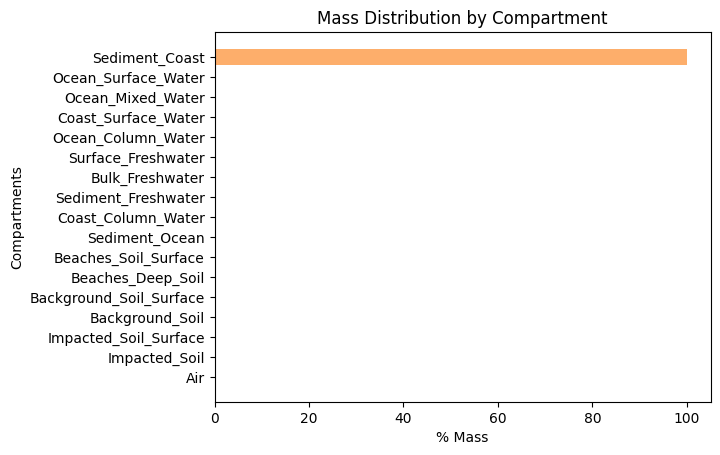

In [35]:
import matplotlib.pyplot as plt

# Assuming you have already defined your custom color mapping from earlier:
compartment_colors = {
    "Ocean_Surface_Water": '#756bb1', 
    "Ocean_Mixed_Water": '#756bb1', 
    "Ocean_Column_Water": '#756bb1', 
    "Coast_Surface_Water": '#2c7fb8', 
    "Coast_Column_Water": '#2c7fb8', 
    "Surface_Freshwater": '#9ebcda', 
    "Bulk_Freshwater": '#9ebcda', 
    "Sediment_Freshwater": '#fdae6b', 
    "Sediment_Ocean": '#fdae6b', 
    "Sediment_Coast": '#fdae6b', 
    "Beaches_Soil_Surface": '#ffeda0', 
    "Beaches_Deep_Soil": '#ffeda0', 
    "Background_Soil_Surface": '#e5f5e0', 
    "Background_Soil": '#e5f5e0', 
    "Impacted_Soil_Surface": '#d95f0e', 
    "Impacted_Soil": '#d95f0e', 
    "Air": '#deebf7'
}

# Add your dataframe sorting and rounding logic
df = results_by_comp[["Compartments", "%_mass"]].round(2).sort_values(by="%_mass", ascending=False)

# Get the list of colors based on the Compartments in the df
bar_colors = df["Compartments"].map(compartment_colors)

# Plot the horizontal bar chart
plt.barh(df["Compartments"], df["%_mass"], color=bar_colors)  # Apply specific colors to each bar
plt.xlabel('% Mass')
plt.ylabel('Compartments')
plt.title('Mass Distribution by Compartment')
plt.gca().invert_yaxis()  # Invert y-axis to match sorting order
plt.show()


In [36]:
results_by_comp[["Compartments","%_number"]].round(2).sort_values(by="%_number", ascending=False)

,Compartments,%_number
9,Sediment_Coast,86.41
8,Sediment_Ocean,8.93
14,Impacted_Soil_Surface,2.25
15,Impacted_Soil,1.08
11,Beaches_Deep_Soil,0.64
2,Ocean_Column_Water,0.51
10,Beaches_Soil_Surface,0.06
13,Background_Soil,0.06
7,Sediment_Freshwater,0.03
16,Air,0.01


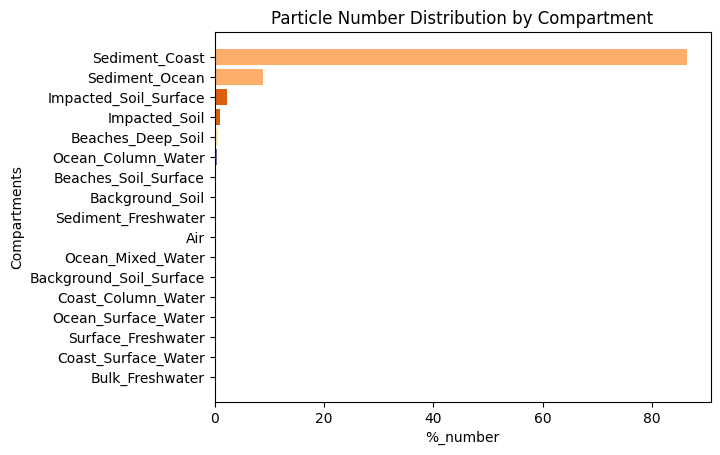

In [37]:
# Add your dataframe sorting and rounding logic
df = results_by_comp[["Compartments", "%_number"]].round(2).sort_values(by="%_number", ascending=False)

# Get the list of colors based on the Compartments in the df
bar_colors = df["Compartments"].map(compartment_colors)

# Plot the horizontal bar chart
plt.barh(df["Compartments"], df["%_number"], color=bar_colors)  # Apply specific colors to each bar
plt.xlabel('%_number')
plt.ylabel('Compartments')
plt.title('Particle Number Distribution by Compartment')
plt.gca().invert_yaxis()  # Invert y-axis to match sorting order
plt.show()

#### Size fraction distribution

In [38]:
## Mass and particle number distribution by size fraction
size_distr = [0.5, 5, 50, 500, 5000]
Pmass = []
Pnumber = []
for size in size_distr:
    Pmass.append(
        round(
            sum(
                Results_extended[Results_extended["Size_Fraction_um"] == size][
                    "mass_g"
                ]
            )
            / sum(Results_extended["mass_g"])
            * 100,
            2,
        )
    )
    Pnumber.append(
        round(
            sum(
                Results_extended[Results_extended["Size_Fraction_um"] == size][
                    "number_of_particles"
                ]
            )
            / sum(Results_extended["number_of_particles"])
            * 100,
            2,
        )
    )

size_distribution_df = pd.DataFrame(
    {
        "Size_Fraction_um": size_distr,
        "% of total mass": Pmass,
        "% of total particle number": Pnumber,
    }
)
size_distribution_df

,Size_Fraction_um,% of total mass,% of total particle number
0,0.5,0.00,19.06
1,5.0,0.00,49.54
2,50.0,0.21,29.53
3,500.0,13.33,1.86
4,5000.0,86.45,0.01


In [39]:
form_distr={}
for form in ["freeMP","heterMP", "biofMP", "heterBiofMP"]:
    form_distr[form]=round(sum(Results_extended[Results_extended["MP_Form"] == form]["number_of_particles"])/sum(Results_extended["number_of_particles"])*100,2)

pd.DataFrame.from_dict(form_distr, orient="index", columns=["% of total particle number"])

,% of total particle number
freeMP,0.05
heterMP,89.08
biofMP,0.00
heterBiofMP,10.87


#### Overall persistence and residence time in years

### Extract input and output flows per compartment


In [40]:
results_comp_extended=add_output_flow_conexions(results_by_comp,dict_comp,outputflow_type="outflows_g_s",inputflow_type="inflows_g_s")
results_comp_extended=add_output_flow_conexions(results_by_comp,dict_comp,outputflow_type="outflows_num_s",inputflow_type="inflows_num_s")

In [41]:
import os
from datetime import datetime
import pandas as pd

# Define a base path (manually set the current working directory if __file__ is not defined)
outputs_path = os.path.join(os.getcwd(), "Results")  # Use the current working directory
current_date = datetime.now().strftime("%Y-%m-%d")
directory = current_date
path = os.path.join(outputs_path, directory)

# Create a subdirectory based on the model run name
subDirectory = current_date + "_All_Compartments"
path_run = os.path.join(path, subDirectory)

# Ensure the directory exists
os.makedirs(path_run, exist_ok=True)

# Example Results DataFrame (replace this with your actual DataFrame)
# Assuming Results is defined elsewhere and already loaded

# Check which columns exist in the DataFrame
existing_columns = Results.columns

# Define the columns to aggregate (only include those that exist in the DataFrame)
aggregation_columns = {
    'mass_g': 'sum',
    'number_of_particles': 'sum',
    'concentration_g_m3': 'sum',
    'concentration_num_m3': 'sum',
    'mass_fraction': 'sum' if 'mass_fraction' in existing_columns else None,
    'number_fraction': 'sum' if 'number_fraction' in existing_columns else None,
}

# Remove None values from aggregation_columns
aggregation_columns = {k: v for k, v in aggregation_columns.items() if v is not None}

# Aggregate the data based on `Compartment` and `Size_Fraction_um`
aggregated_results = Results.groupby(['Compartment', 'Size_Fraction_um']).agg(**{
    col: (col, agg_func) for col, agg_func in aggregation_columns.items()
}).reset_index()

# Calculate relative abundance for each compartment (as a percentage)
aggregated_results['relative_abundance'] = aggregated_results.groupby('Compartment')['concentration_num_m3'].transform(
    lambda x: (x / x.sum()) * 100
)

# Calculate percentage of number_of_particles within each compartment
aggregated_results['percentage_number_of_particles'] = aggregated_results.groupby('Compartment')['number_of_particles'].transform(
    lambda x: (x / x.sum()) * 100
)

# Select only the columns that exist in the aggregated DataFrame
output_columns = [
    'Compartment', 
    'Size_Fraction_um', 
    'mass_g', 
    'number_of_particles', 
    'percentage_number_of_particles',
    'concentration_g_m3', 
    'concentration_num_m3', 
    'mass_fraction', 
    'number_fraction', 
    'relative_abundance'
]

output_columns = [col for col in output_columns if col in aggregated_results.columns]

# Extract the relevant columns for the final output
aggregated_results_output = aggregated_results[output_columns]

# Save the aggregated and formatted results to a new Excel file
output_excel_path = os.path.join(path_run, "Aggregated_All_Compartments_Results.xlsx")
aggregated_results_output.to_excel(output_excel_path, index=False)
print(f"Aggregated results for all compartments saved to {output_excel_path}")


Aggregated results for all compartments saved to c:\Users\rakes\Pictures\Model\UTOPIA_model-main\Results\2025-02-09\2025-02-09_All_Compartments\Aggregated_All_Compartments_Results.xlsx


Bring the reference data sets

Observed Data Preview:
   Size1  Abundance1  Size2  Abundance2  Size3  Abundance3  Size4  Abundance4  \
0   11.0   57.044493   75.0        41.0   10.0   19.625850  100.0       10.48   
1   18.0   21.884237  125.0        23.5   20.0   15.782313  200.0        8.10   
2   37.5   14.630525  175.0         9.5   30.0   15.408163  300.0        7.50   
3   62.5    3.656641  225.0         7.0   40.0   12.176871  400.0        8.98   
4   87.5    1.868927  275.0         3.5   50.0    8.503401  500.0        8.10   

   Size5  Abundance5  ...  Size14  Abundance14  Size15  Abundance15  Size16  \
0   75.0   30.667957  ...   450.0     9.151960   500.0    70.387021   125.0   
1  125.0   28.673766  ...   550.0     6.845601  1000.0    15.004121   175.0   
2  175.0   14.424008  ...   650.0     4.599564  1500.0     0.730572   225.0   
3  225.0    7.531462  ...   750.0     9.145864  2000.0     1.262221   275.0   
4  275.0    5.072604  ...   850.0     4.595713  2500.0     2.433463   325.0   

   Abundance16 

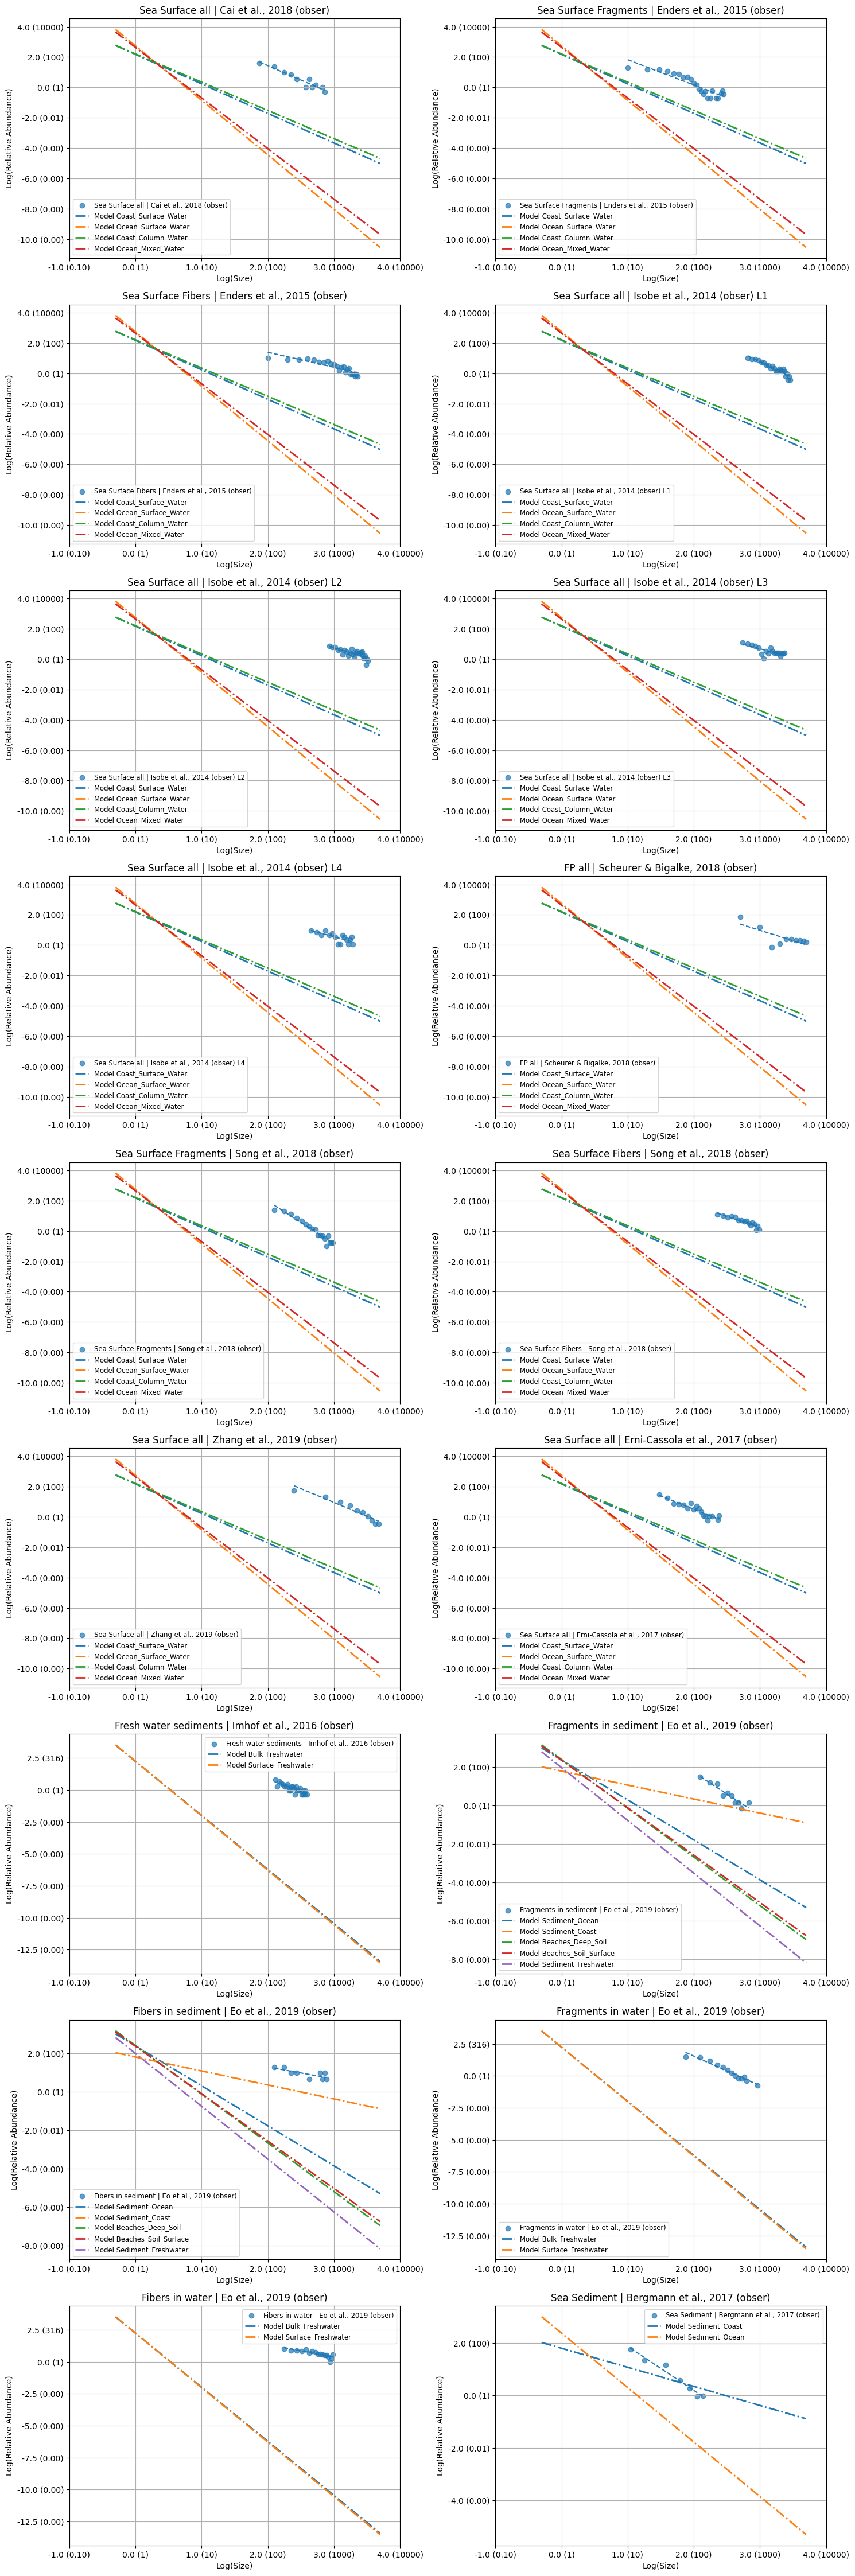

Model run: 
Emissions flow (g/s):  250000
Receiving compartment/s:  Coast_Surface_Water
Emitted MP density (kg/m3):  1580
Emitted MP shape:  sphere
Emitted MP form:  freeMP
Emitted MP size (um):  5000.0
PE_MP_Emissions_freeMP_5000.0_nm__FI:1


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FuncFormatter

# ======================================
# 1. Process the Observed Data
# ======================================
file_path = "your_dataset.xlsx"  # Update with your actual file path
observed_data = pd.read_excel(file_path)
print("Observed Data Preview:")
print(observed_data.head())

# Create a dictionary of processed observed datasets.
processed_data = {}
columns = observed_data.columns
num_datasets = len(columns) // 2  # Each dataset has a Size and an Abundance column

for i in range(1, num_datasets + 1):
    size_col = f"Size{i}"
    abundance_col = f"Abundance{i}"
    df = observed_data[[size_col, abundance_col]].dropna()  # Remove rows with NaN values
    df = df[df[abundance_col] > 0]                           # Exclude rows with 0 or negative abundance
    df['log_size'] = np.log10(df[size_col])
    df['log_abundance'] = np.log10(df[abundance_col])
    processed_data[f"Dataset{i}"] = df

# Dictionary of observed dataset names with updated names for Datasets 11–14.
dataset_names = {
    "Dataset1": "Sea Sediment | Bergmann et al., 2017 (obser)",
    "Dataset2": "Sea Surface all | Cai et al., 2018 (obser)",
    "Dataset3": "Sea Surface Fragments | Enders et al., 2015 (obser)",
    "Dataset4": "Sea Surface Fibers | Enders et al., 2015 (obser)",
    "Dataset5": "Fragments in water | Eo et al., 2019 (obser)",
    "Dataset6": "Fibers in water | Eo et al., 2019 (obser)",
    "Dataset7": "Fragments in sediment | Eo et al., 2019 (obser)",
    "Dataset8": "Fibers in sediment | Eo et al., 2019 (obser)",
    "Dataset9": "Sea Surface all | Erni-Cassola et al., 2017 (obser)",
    "Dataset10": "Fresh water sediments | Imhof et al., 2016 (obser)",
    "Dataset11": "Sea Surface all | Isobe et al., 2014 (obser) L1",
    "Dataset12": "Sea Surface all | Isobe et al., 2014 (obser) L2",
    "Dataset13": "Sea Surface all | Isobe et al., 2014 (obser) L3",
    "Dataset14": "Sea Surface all | Isobe et al., 2014 (obser) L4",
    "Dataset15": "FP all | Scheurer & Bigalke, 2018 (obser)",
    "Dataset16": "Sea Surface Fragments | Song et al., 2018 (obser)",
    "Dataset17": "Sea Surface Fibers | Song et al., 2018 (obser)",
    "Dataset18": "Sea Surface all | Zhang et al., 2019 (obser)"
}

# ----------------------------------
# Define a mapping from each observed dataset (using its base name)
# to the list of model compartments to overlay.
# Note: The Isobe datasets are explicitly mapped with L1, L2, L3, L4.
# ----------------------------------
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann et al., 2017": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai et al., 2018": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface Fragments | Enders et al., 2015": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface Fibers | Enders et al., 2015": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Fragments in water | Eo et al., 2019": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo et al., 2019": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo et al., 2019": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil", "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Fibers in sediment | Eo et al., 2019": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil", "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola et al., 2017": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Fresh water sediments | Imhof et al., 2016": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe et al., 2014 L1": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface all | Isobe et al., 2014 L2": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface all | Isobe et al., 2014 L3": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface all | Isobe et al., 2014 L4": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "FP all | Scheurer & Bigalke, 2018": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface Fragments | Song et al., 2018": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface Fibers | Song et al., 2018": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"],
    "Sea Surface all | Zhang et al., 2019": ["Coast_Surface_Water", "Ocean_Surface_Water", "Coast_Column_Water", "Ocean_Mixed_Water"]
}

# ======================================
# 2. Process the Model Simulation Output
# ======================================
# (Assume that 'aggregated_results' is your model DataFrame.)
data_model = aggregated_results[aggregated_results['relative_abundance'] > 0].copy()
data_model['log_size'] = np.log10(data_model['Size_Fraction_um'])
data_model['log_abundance'] = np.log10(data_model['relative_abundance'])

# Compute a trendline for each model compartment.
compartment_trendlines = {}
for comp in data_model['Compartment'].unique():
    comp_data = data_model[data_model['Compartment'] == comp]
    if len(comp_data) > 1:
        coeffs = np.polyfit(comp_data['log_size'], comp_data['log_abundance'], 1)
        trendline_func = np.poly1d(coeffs)
        x_vals = np.linspace(comp_data['log_size'].min(), comp_data['log_size'].max(), 100)
        y_vals = trendline_func(x_vals)
        compartment_trendlines[comp] = (x_vals, y_vals)

# For model overlay trendlines, use the tab10 color cycle.
model_colors = plt.get_cmap("tab10").colors

# ======================================
# 3. Define a Custom Tick Formatter
# ======================================
def custom_formatter(x, pos):
    """
    Format tick labels so that they display:
      <log_value> (<antilog_value>)
    For example, if x = 2.0 then this returns "2.0 (100)".
    """
    original_val = 10 ** x
    if original_val >= 1:
        orig_str = f"{original_val:.0f}"
    else:
        orig_str = f"{original_val:.2f}"
    return f"{x:.1f} ({orig_str})"

# ======================================
# 4. Plot each Observed Dataset with Model Overlays in the Desired Order
# ======================================
# Define the order exactly as you requested.
ordered_keys = [
    "Dataset2",  # Sea Surface all | Cai et al., 2018 
    "Dataset3",  # Sea Surface Fragments | Enders et al., 2015 
    "Dataset4",  # Sea Surface Fibers | Enders et al., 2015 
    "Dataset11", # Sea Surface all | Isobe et al., 2014 L1 
    "Dataset12", # Sea Surface all | Isobe et al., 2014 L2 
    "Dataset13", # Sea Surface all | Isobe et al., 2014 L3 
    "Dataset14", # Sea Surface all | Isobe et al., 2014 L4 
    "Dataset15", # FP all | Scheurer & Bigalke, 2018 
    "Dataset16", # Sea Surface Fragments | Song et al., 2018 
    "Dataset17", # Sea Surface Fibers | Song et al., 2018 
    "Dataset18", # Sea Surface all | Zhang et al., 2019 
    "Dataset9",  # Sea Surface all | Erni-Cassola et al., 2017 
    "Dataset10", # Fresh water sediments | Imhof et al., 2016 
    "Dataset7",  # Fragments in sediment | Eo et al., 2019 
    "Dataset8",  # Fibers in sediment | Eo et al., 2019 
    "Dataset5",  # Fragments in water | Eo et al., 2019 
    "Dataset6",  # Fibers in water | Eo et al., 2019 
    "Dataset1"   # Sea Sediment | Bergmann et al., 2017 
]

n_datasets = len(ordered_keys)
rows = math.ceil(n_datasets / 2)
fig, axs = plt.subplots(rows, 2, figsize=(15, rows * 5))
axs = axs.flatten()

# Loop through the ordered keys for plotting.
for i, dataset_key in enumerate(ordered_keys):
    df = processed_data[dataset_key]
    ax = axs[i]
    
    full_title = dataset_names.get(dataset_key, dataset_key)
    ax.scatter(df['log_size'], df['log_abundance'], label=full_title, alpha=0.7)
    
    # Optionally, plot an observed trendline.
    if len(df) > 1:
        coeffs = np.polyfit(df['log_size'], df['log_abundance'], 1)
        trendline_func = np.poly1d(coeffs)
        x_vals = np.linspace(df['log_size'].min(), df['log_size'].max(), 100)
        ax.plot(x_vals, trendline_func(x_vals), linestyle='--', label="_nolegend_")
    
    # Remove the " (obser)" suffix for matching overlay mapping.
    base_title = full_title.replace(" (obser)", "").strip()
    if base_title in overlay_compartments_mapping:
        compartments_to_overlay = overlay_compartments_mapping[base_title]
        for j, comp in enumerate(compartments_to_overlay):
            if comp in compartment_trendlines:
                x_vals_model, y_vals_model = compartment_trendlines[comp]
                color = model_colors[j % len(model_colors)]
                ax.plot(x_vals_model, y_vals_model, color=color, linestyle='-.', linewidth=2,
                        label=f"Model {comp}")
    
    ax.set_xlabel("Log(Size)")
    ax.set_ylabel("Log(Relative Abundance)")
    ax.set_title(full_title)
    ax.grid(True)
    ax.legend(fontsize='small', loc='best')
    
    # Apply the custom tick formatter to both axes.
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
    
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.arange(np.floor(xmin), np.ceil(xmax) + 1, 1))

# Remove any extra subplots if they exist.
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# ======================================
# (Optional) Print model run summary (ensure these variables are defined)
# ======================================
print("Model run: ")
print("Emissions flow (g/s): ", input_flow_g_s)
desired_key = next(key for key, value in q_mass_g_s_dict.items() if value > 0)
print("Receiving compartment/s: ", desired_key)
print("Emitted MP density (kg/m3): ", MPdensity_kg_m3)
print("Emitted MP shape: ", shape)
print("Emitted MP form: ", MP_form)
print("Emitted MP size (um): ", size_dict[size_bin])
print(saveName)
